In [ ]:
# !pip install bert-for-tf2
# !wget https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip
# !unzip embeddings/bert/wwm_uncased_L-24_H-1024_A-16.zip

In [1]:
%load_ext lab_black

# BERT embedding
- Multiple versions of pretrained BERT are available on https://github.com/google-research/bert
    - Versions varies in:
        - BERT layer (L), 
        - Hidden unit (H), 
        - Attention head (A), 
        - Training set cases or not (cased, uncased)
        - Masking stregegy (Whole word masking (wwm), or wwm + sublexical mask)
    - For example, the base model (uncased_L-12_H-768_A-12), it has 12 BERT layers, 768 hidden unit, and 12 attention head which trained on uncased training set with sublexical information into account
- Non wwm masking encode a single word into >=1 tokens(e.g., hat maybe encoded into two tokens: hat-, and -s), therefore it needs a longer sequence (max_seq_len) to encode a single word
- For whole word masking models (e.g. wwm_uncased_L-24_H-1024_A-16), bert only need 1 cell to encode each word
- Because BERT is designed to encode sentence level information, 2 special tokens are needed to mark the start [CLS] and the end [SEP] of a sentence/word
    - However, testing the word level similarity matrix, including these special tokens harms the similarity between highly related word pairs
    - Therefore, I do not include the special token when applying BERT


## Create BERT model from file

In [3]:
from tensorflow import keras
import os, bert
import pandas as pd
import numpy as np

def simple_load_bert(model_dir, max_seq_len):
    """
    Building a tensorflow model with pretrained model

    """

    bert_params = bert.params_from_pretrained_ckpt(model_dir)
    l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

    # Since BERT also uses sublexical info (e.g., -s, -ed), for a single word 8 is enough for our corpus
    l_input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32')

    # using the default token_type
    # output: [batch_size, max_seq_len, hidden_size]
    output = l_bert(l_input_ids)
    model = keras.Model(inputs=l_input_ids, outputs=output)

    # Build and load checkpoint weights
    model.build(input_shape=(None, max_seq_len))
    bert_ckpt_file = os.path.join(model_dir, "bert_model.ckpt")
    bert.load_stock_weights(l_bert, bert_ckpt_file)
    return model


model_dir = 'embeddings/bert/wwm_uncased_L-24_H-1024_A-16'
max_seq_len = 1
model = simple_load_bert(model_dir, max_seq_len)

Done loading 388 BERT weights from: embeddings/bert/wwm_uncased_L-24_H-1024_A-16/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fd3a4415470> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


## Tokenize training set with BERT token id

In [6]:
from bert.tokenization.bert_tokenization import BasicTokenizer, load_vocab, convert_by_vocab

tokenizer = BasicTokenizer()
vocab = load_vocab(os.path.join(model_dir, "vocab.txt"))

x_train = pd.read_csv('../common/input/df_train.csv', na_filter=False)
print('Training set has {} words'.format(len(x_train)))

words = []
x = []

for i, word in enumerate(x_train.word):
    if word in vocab:
        words.append(word)
        x.append(convert_by_vocab(vocab, tokenizer.tokenize(word)))

print('There are {} words with BERT vector'.format(len(x)))

Training set has 5832 words
There are 3451 words with BERT vector


## Use BERT to create word embedding

In [9]:
y = model.predict(x)
print('y shape (words, seq, hidden) = {}'.format(y.shape))

# Can use different pooling stregegy is seq dim > 1
y = y.squeeze()
# y = np.mean(y, axis=1)
# y = np.max(y, axis=1)

print('After squeezing seq dimension, shoep = {}'.format(y.shape))

y shape (words, seq, hidden) = (3451, 1024)
After squeezing seq dimension, shoep = (3451, 1024)


### Visualize embedding

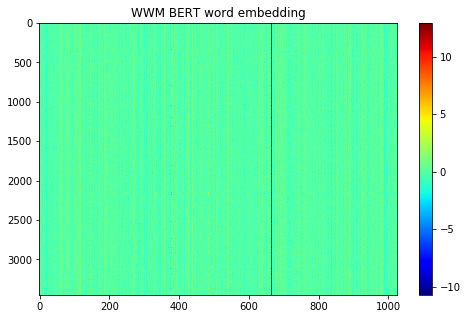

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.subplot(111)
plt.title('WWM BERT word embedding')
plt.imshow(y, cmap='jet', interpolation='nearest', aspect="auto")
plt.colorbar()
plt.show()

### Tiny test case
- Check whether similar words are really similar at the embedding
- Consider expanding to full blown test case using free association norm http://w3.usf.edu/FreeAssociation/

In [29]:
from tensorflow.keras.losses import cosine_similarity


def check_sim():
    """
    A test case for checking the embedding is providing sensible similarity measure
    """

    fire = y[[i for i, word in enumerate(words) if word == 'fire']]
    heat = y[[i for i, word in enumerate(words) if word == 'heat']]
    boy = y[[i for i, word in enumerate(words) if word == 'boy']]
    girl = y[[i for i, word in enumerate(words) if word == 'girl']]

    print(
        'Cosine similarity range from -1 to 1, more positive indicate higher similarity'
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'fire', 'heat', -cosine_similarity(fire, heat)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'fire', 'boy', -cosine_similarity(fire, boy)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'fire', 'girl', -cosine_similarity(fire, girl)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'heat', 'boy', -cosine_similarity(heat, boy)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'heat', 'girl', -cosine_similarity(heat, girl)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'boy', 'girl', -cosine_similarity(boy, girl)
        )
    )


check_sim()

Cosine similarity range from -1 to 1, more positive indicate higher similarity
Similarity between fire and heat is [0.99997556]
Similarity between fire and boy is [-0.1788176]
Similarity between fire and girl is [-0.17969546]
Similarity between heat and boy is [-0.1797307]
Similarity between heat and girl is [-0.18061507]
Similarity between boy and girl is [0.8601125]


### Save embedding

In [28]:
np.savez_compressed('embeddings/bert/bert.npz', data=y)

with open('embeddings/bert/bert_wordlist.txt', 'w') as file:
    file.writelines("%s\n" % word for word in words)

print('{} words in bert.npz'.format(len(x)))

3451 words in bert.npz
